In [1]:
import sys
import os
from pathlib import Path

root_path = str(Path(os.getcwd()).parents[3])
sys.path.append(root_path)

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import os

import mercury.viz
import matplotlib.pyplot as plt
plt.style.use('mercury')

In [3]:
env = gym.make('MountainCar-v0')

In [4]:
def create_grid(low, high, bins=(10,10)):
    x = np.linspace(low[0], high[0], bins[0], endpoint=False)[1:]
    v = np.linspace(low[1], high[1], bins[1], endpoint=False)[1:]
    return [x, v]

def discretize(state, grid):
    x = np.digitize(state[0], grid[0])
    v = np.digitize(state[1], grid[1])
    return tuple([x,v])

def agent(s, q_table, epsilon = 1.0):
    random = np.random.uniform(0, 1)
    if random < epsilon:
        a = env.action_space.sample()
    else:
        a = np.argmax(q_table[s])
    return a

In [5]:
low = env.observation_space.low
high = env.observation_space.high

grid = create_grid(low, high)

In [6]:
state = env.observation_space.sample()
state_disc = discretize(state, grid)

In [7]:
EPISODES = 3000
lr = 0.01
gamma = 0.99
epsilon = 1.0

q_table = np.zeros((10, 10, 3))

data = {'episode_id':[], 'seq':[],'x':[],'vel':[], 'action':[], 'reward':[]}

for i in range(EPISODES):

    curr_state, info = env.reset()
    
    total_R = 0
    j = 0
    
    while True:
        s = discretize(curr_state, grid)
        a = agent(s, q_table, epsilon)
        
        next_state, reward, terminated, _, _ = env.step(a)
        next_state_disc = discretize(next_state, grid)
        
        # Training
        q_table[s + (a,)] = q_table[s + (a,) ] + lr * (reward + gamma * max(q_table[next_state_disc]) - q_table[s + (a,)])
        
        # Save data
        data['episode_id'].append(i)
        data['seq'].append(j)
        data['x'].append(curr_state[0])
        data['vel'].append(curr_state[1])
        data['action'].append(a)
        data['reward'].append(reward)
        
        curr_state = next_state
        total_R += reward
        j += 1
        
        if terminated or j > 500:
            break
        
    
    epsilon *= 0.99
    epsilon = max(epsilon, 0.01)
    
    
    print("EPISODE:", i, "TOTAL REWARD:", total_R)

EPISODE: 0 TOTAL REWARD: -501.0
EPISODE: 1 TOTAL REWARD: -501.0
EPISODE: 2 TOTAL REWARD: -501.0
EPISODE: 3 TOTAL REWARD: -501.0
EPISODE: 4 TOTAL REWARD: -501.0
EPISODE: 5 TOTAL REWARD: -501.0
EPISODE: 6 TOTAL REWARD: -501.0
EPISODE: 7 TOTAL REWARD: -501.0
EPISODE: 8 TOTAL REWARD: -501.0
EPISODE: 9 TOTAL REWARD: -501.0
EPISODE: 10 TOTAL REWARD: -501.0
EPISODE: 11 TOTAL REWARD: -501.0
EPISODE: 12 TOTAL REWARD: -501.0
EPISODE: 13 TOTAL REWARD: -501.0
EPISODE: 14 TOTAL REWARD: -501.0
EPISODE: 15 TOTAL REWARD: -501.0
EPISODE: 16 TOTAL REWARD: -501.0
EPISODE: 17 TOTAL REWARD: -501.0
EPISODE: 18 TOTAL REWARD: -501.0
EPISODE: 19 TOTAL REWARD: -501.0
EPISODE: 20 TOTAL REWARD: -501.0
EPISODE: 21 TOTAL REWARD: -501.0
EPISODE: 22 TOTAL REWARD: -501.0
EPISODE: 23 TOTAL REWARD: -501.0
EPISODE: 24 TOTAL REWARD: -501.0
EPISODE: 25 TOTAL REWARD: -501.0
EPISODE: 26 TOTAL REWARD: -501.0
EPISODE: 27 TOTAL REWARD: -501.0
EPISODE: 28 TOTAL REWARD: -501.0
EPISODE: 29 TOTAL REWARD: -501.0
EPISODE: 30 TOTAL RE

In [8]:
df = pd.DataFrame(data=data)
df

,episode_id,seq,x,vel,action,reward
0,0,0,-0.521329,0.000000,1,-1.0
1,0,1,-0.521346,-0.000017,1,-1.0
2,0,2,-0.521380,-0.000034,2,-1.0
3,0,3,-0.520430,0.000949,1,-1.0
4,0,4,-0.519505,0.000926,2,-1.0
...,...,...,...,...,...,...
933234,2999,264,0.394050,0.024685,2,-1.0
933235,2999,265,0.418788,0.024738,2,-1.0
933236,2999,266,0.443752,0.024965,2,-1.0
933237,2999,267,0.469124,0.025372,1,-1.0


## Filtering Expert

In [9]:
df_agg = df.groupby("episode_id", as_index=False).agg(total_reward=("reward", "sum")).sort_values(by="total_reward", ascending=True)
df_agg = df_agg.reset_index(drop=True)
df_agg

,episode_id,total_reward
0,1190,-501.0
1,79,-501.0
2,54,-501.0
3,1,-501.0
4,2,-501.0
...,...,...
2995,2251,-117.0
2996,2299,-116.0
2997,1819,-116.0
2998,2405,-115.0


<Axes: >

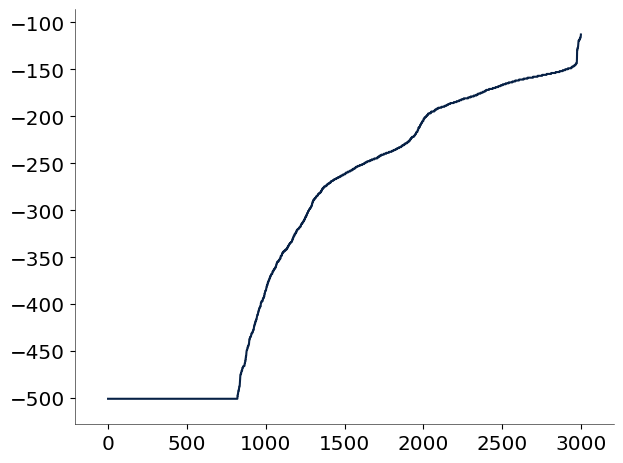

In [10]:
df_agg.total_reward.plot.line() 

In [11]:
episodes = df_agg[df_agg.total_reward >= -200].sort_values(by=["total_reward"], ascending=True)['episode_id'].values

In [13]:
df_batch = pd.concat([df[df.episode_id == i] for i in episodes], ignore_index=True)
df_batch['episode_id'] = df_batch.groupby('episode_id', sort=False).ngroup()
# df_batch.to_csv("data/MountainCarExpert.csv", index=False)
df_batch


,episode_id,seq,x,vel,action,reward
0,0,0,-0.414160,0.000000,2,-1.0
1,0,1,-0.413966,0.000194,2,-1.0
2,0,2,-0.413580,0.000386,2,-1.0
3,0,3,-0.413004,0.000576,2,-1.0
4,0,4,-0.412242,0.000762,2,-1.0
...,...,...,...,...,...,...
165324,982,108,0.356719,0.033000,2,-1.0
165325,982,109,0.389518,0.032800,2,-1.0
165326,982,110,0.422340,0.032821,0,-1.0
165327,982,111,0.453413,0.031073,1,-1.0


In [14]:
folder_path = root_path + "/data/MountainCar"

In [ ]:
def generate_batches(df, root_path: str, batch_size: int):
    
    os.system('rm -rf ' + folder_path + '/*')
    episodes = df.episode_id.unique()
    for i in range(0, len(episodes), batch_size):
        file = folder_path + "/partition_" + str(i) + ".csv"
        df_batch = df[df.episode_id.isin(episodes[i : (i + batch_size)])]
        df_batch.to_csv(file, index=False)
    

In [18]:
generate_batches(df_batch, root_path, batch_size=2)